# Deep Autoencoding Gaussian Mixture Model for Unsupervised Anomaly Detection

In [1]:
import numpy as np 
import pandas as pd
import torch
from data_loader import *
from main import *
from tqdm import tqdm

## KDD Cup 1999 Data (10% subset)
This is the data set used for The Third International Knowledge Discovery and Data Mining Tools Competition, which was held in conjunction with KDD-99 The Fifth International Conference on Knowledge Discovery and Data Mining. The competition task was to build a network intrusion detector, a predictive model capable of distinguishing between "bad" connections, called intrusions or attacks, and "good" normal connections. This database contains a standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment. 

In [2]:
transaction_data = pd.read_csv("ieee-fraud-detection/train_transaction.csv", header=0)
transaction_data

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
identity_data = pd.read_csv("ieee-fraud-detection/train_identity.csv", header=0)
identity_data

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144228,3577521,-15.0,145955.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 66.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,F3111 Build/33.3.A.1.97
144229,3577526,-5.0,172059.0,NaN,NaN,1.0,-5.0,NaN,NaN,NaN,...,chrome 55.0 for android,32.0,855x480,match_status:2,T,F,T,F,mobile,A574BL Build/NMF26F
144230,3577529,-20.0,632381.0,NaN,NaN,-1.0,-36.0,NaN,NaN,NaN,...,chrome 65.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,Moto E (4) Plus Build/NMA26.42-152
144231,3577531,-5.0,55528.0,0.0,0.0,0.0,-7.0,NaN,NaN,0.0,...,chrome 66.0,24.0,2560x1600,match_status:2,T,F,T,F,desktop,MacOS


In [4]:
data = transaction_data.set_index('TransactionID').join(identity_data.set_index('TransactionID'))
data

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Pre-processing
"isFraud" = 0 -> normal, "isFraud" = 1 -> anomaly. 

Next, the categorical variables are converted to a one hot encoding representation. My implementation is a bit different from the original paper in this aspect. Since I am only using the 10% subset to generate the columns, I get 118 features instead of 120 as reported in the paper.

In [5]:
one_hot_ProductCD = pd.get_dummies(data["ProductCD"])
one_hot_card4 = pd.get_dummies(data["card4"])
one_hot_card6 = pd.get_dummies(data["card6"])
one_hot_Pemaildomain = pd.get_dummies(data["P_emaildomain"])
one_hot_Remaildomain = pd.get_dummies(data["R_emaildomain"])
one_hot_M1 = pd.get_dummies(data["M1"])
one_hot_M2 = pd.get_dummies(data["M2"])
one_hot_M3 = pd.get_dummies(data["M3"])
one_hot_M4 = pd.get_dummies(data["M4"])
one_hot_M5 = pd.get_dummies(data["M5"])
one_hot_M6 = pd.get_dummies(data["M6"])
one_hot_M7 = pd.get_dummies(data["M7"])
one_hot_M8 = pd.get_dummies(data["M8"])
one_hot_M9 = pd.get_dummies(data["M9"])
one_hot_id12 = pd.get_dummies(data["id_12"])
one_hot_id15 = pd.get_dummies(data["id_15"])
one_hot_id16 = pd.get_dummies(data["id_16"])
one_hot_id23 = pd.get_dummies(data["id_23"])
one_hot_id27 = pd.get_dummies(data["id_27"])
one_hot_id28 = pd.get_dummies(data["id_28"])
one_hot_id29 = pd.get_dummies(data["id_29"])
one_hot_id30 = pd.get_dummies(data["id_30"])
one_hot_id31 = pd.get_dummies(data["id_31"])
one_hot_id33 = pd.get_dummies(data["id_33"])
one_hot_id34 = pd.get_dummies(data["id_34"])
one_hot_id35 = pd.get_dummies(data["id_35"])
one_hot_id36 = pd.get_dummies(data["id_36"])
one_hot_id37 = pd.get_dummies(data["id_37"])
one_hot_id38 = pd.get_dummies(data["id_38"])
one_hot_DeviceType = pd.get_dummies(data["DeviceType"])
one_hot_DeviceInfo = pd.get_dummies(data["DeviceInfo"])

In [6]:
data = data.drop("ProductCD",axis=1)
data = data.drop("card4",axis=1)
data = data.drop("card6",axis=1)
data = data.drop("P_emaildomain",axis=1)
data = data.drop("R_emaildomain",axis=1)
data = data.drop("M1",axis=1)
data = data.drop("M2",axis=1)
data = data.drop("M3",axis=1)
data = data.drop("M4",axis=1)
data = data.drop("M5",axis=1)
data = data.drop("M6",axis=1)
data = data.drop("M7",axis=1)
data = data.drop("M8",axis=1)
data = data.drop("M9",axis=1)
data = data.drop("id_12",axis=1)
data = data.drop("id_15",axis=1)
data = data.drop("id_16",axis=1)
data = data.drop("id_23",axis=1)
data = data.drop("id_27",axis=1)
data = data.drop("id_28",axis=1)
data = data.drop("id_29",axis=1)
data = data.drop("id_30",axis=1)
data = data.drop("id_31",axis=1)
data = data.drop("id_33",axis=1)
data = data.drop("id_34",axis=1)
data = data.drop("id_35",axis=1)
data = data.drop("id_36",axis=1)
data = data.drop("id_37",axis=1)
data = data.drop("id_38",axis=1)
data = data.drop("DeviceType",axis=1)
data = data.drop("DeviceInfo",axis=1)

In [8]:
data = pd.concat([one_hot_ProductCD, one_hot_card4, one_hot_card6, 
                  one_hot_Pemaildomain, one_hot_Remaildomain, one_hot_M1, 
                  one_hot_M2, one_hot_M3, one_hot_M4, 
                  one_hot_M5, one_hot_M6, one_hot_M7, 
                  one_hot_M8, one_hot_M9, one_hot_id12, 
                  one_hot_id15, one_hot_id16, one_hot_id23, 
                  one_hot_id27, one_hot_id28, one_hot_id29, 
                  one_hot_id30, one_hot_id31, one_hot_id33, 
                  one_hot_id34, one_hot_id35, one_hot_id36, 
                  one_hot_id37, one_hot_id38, one_hot_DeviceType, 
                  one_hot_DeviceInfo, data],axis=1)
data.head()

,C,H,R,S,W,american express,discover,mastercard,visa,charge card,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,0,0,0,1,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,0,0,0,1,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,0,0,0,1,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,0,0,0,1,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,1,0,0,0,0,0,1,0,0,...,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,32.0


In [12]:
#data.loc[:,"SAMSUNG SM-G892A Build/NRD90M"]

TransactionID
2987000    0
2987001    0
2987002    0
2987003    0
2987004    1
          ..
3577535    0
3577536    0
3577537    0
3577538    0
3577539    0
Name: SAMSUNG SM-G892A Build/NRD90M, Length: 590540, dtype: uint8

In [13]:
proportions = data["isFraud"].value_counts()
print(proportions)
print("Anomaly Percentage",proportions[1] / proportions.sum())

0    569877
1     20663
Name: isFraud, dtype: int64
Anomaly Percentage 0.03499000914417313


In [6]:
#proportions_alfa = data["type"].value_counts(normalize=True)
#print(proportions_alfa)

Normalize all the numeric variables.

In [7]:
cols_to_norm = ["duration", "src_bytes", "dst_bytes", "wrong_fragment", "urgent", 
            "hot", "num_failed_logins", "num_compromised", "num_root", 
            "num_file_creations", "num_shells", "num_access_files", "count", "srv_count", 
            "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", 
            "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", 
            "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", 
            "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate" ]

#data.loc[:, cols_to_norm] = (data[cols_to_norm] - data[cols_to_norm].mean()) / data[cols_to_norm].std()
min_cols = data.loc[data["type"]==0 , cols_to_norm].min()
max_cols = data.loc[data["type"]==0 , cols_to_norm].max()

data.loc[:, cols_to_norm] = (data[cols_to_norm] - min_cols) / (max_cols - min_cols)

I saved the preprocessed data into a numpy file format and load it using the pytorch data loader.

In [8]:
np.savez_compressed("kdd_cup",kdd=data.as_matrix())

C:\Users\cncluser\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


I initially implemented this to be ran in the command line and use argparse to get the hyperparameters. To make it runnable in a jupyter notebook, I had to create a dummy class for the hyperparameters.

In [9]:
class hyperparams():
    def __init__(self, config):
        self.__dict__.update(**config)
defaults = {
    'lr' : 1e-4,
    'num_epochs' : 200,
    'batch_size' : 1024,
    'gmm_k' : 4,
    'lambda_energy' : 0.1,
    'lambda_cov_diag' : 0.005,
    'pretrained_model' : None,
    'mode' : 'train',
    'use_tensorboard' : False,
    'data_path' : 'kdd_cup.npz',

    'log_path' : './dagmm/logs',
    'model_save_path' : './dagmm/models',
    'sample_path' : './dagmm/samples',
    'test_sample_path' : './dagmm/test_samples',
    'result_path' : './dagmm/results',

    'log_step' : 194//4,
    'sample_step' : 194,
    'model_save_step' : 194,
}

Elapsed 0:00:13.076672/0:00:07.943268 -- 0:34:43.567725 , Epoch [2/200], Iter [48/194], lr 0.0001, total_loss: 0.1430, sample_energy: -2.4255, recon_error: 0.0624, cov_diag: 64.6240


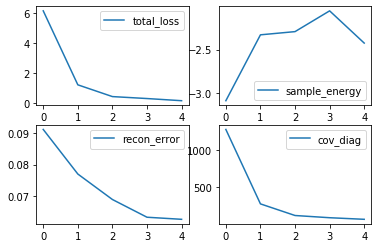

phi tensor([0.2356, 0.1980, 0.3282, 0.2383]) mu tensor([[-0.5328,  0.8382,  0.5090],
        [-0.4987,  0.8608,  0.4772],
        [-0.4941,  0.8639,  0.4729],
        [-0.5665,  0.8157,  0.5406]]) cov tensor([[[ 0.2696,  0.1789, -0.2516],
         [ 0.1789,  0.1193, -0.1676],
         [-0.2516, -0.1676,  0.2355]],

        [[ 0.2868,  0.1903, -0.2676],
         [ 0.1903,  0.1268, -0.1781],
         [-0.2676, -0.1781,  0.2504]],

        [[ 0.2885,  0.1915, -0.2693],
         [ 0.1915,  0.1275, -0.1792],
         [-0.2693, -0.1792,  0.2519]],

        [[ 0.2497,  0.1658, -0.2331],
         [ 0.1658,  0.1105, -0.1553],
         [-0.2331, -0.1553,  0.2182]]])


 29%|███████████████████████▊                                                         | 57/194 [00:03<00:07, 17.44it/s]


KeyboardInterrupt: 

In [10]:
solver = main(hyperparams(defaults))
accuracy, precision, recall, f_score = solver.test()

### I copy pasted the testing code here in the notebook so we could play around the results.

### Incrementally compute for the GMM parameters across all training data for a better estimate

In [ ]:
solver.data_loader.dataset.mode="train"
solver.dagmm.eval()
N = 0
mu_sum = 0
cov_sum = 0
gamma_sum = 0

for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    phi, mu, cov = solver.dagmm.compute_gmm_params(z, gamma)
    
    batch_gamma_sum = torch.sum(gamma, dim=0)
    
    gamma_sum += batch_gamma_sum
    mu_sum += mu * batch_gamma_sum.unsqueeze(-1) # keep sums of the numerator only
    cov_sum += cov * batch_gamma_sum.unsqueeze(-1).unsqueeze(-1) # keep sums of the numerator only
    
    N += input_data.size(0)
    
train_phi = gamma_sum / N
train_mu = mu_sum / gamma_sum.unsqueeze(-1)
train_cov = cov_sum / gamma_sum.unsqueeze(-1).unsqueeze(-1)

print("N:",N)
print("phi :\n",train_phi)
print("mu :\n",train_mu)
print("cov :\n",train_cov)

In [ ]:
train_energy = []
train_labels = []
train_z = []
for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    sample_energy, cov_diag = solver.dagmm.compute_energy(z, phi=train_phi, mu=train_mu, cov=train_cov, size_average=False)
    
    train_energy.append(sample_energy.data.cpu().numpy())
    train_z.append(z.data.cpu().numpy())
    train_labels.append(labels.numpy())


train_energy = np.concatenate(train_energy,axis=0)
train_z = np.concatenate(train_z,axis=0)
train_labels = np.concatenate(train_labels,axis=0)

### Compute the energy of every sample in the test data

In [ ]:
solver.data_loader.dataset.mode="test"
test_energy = []
test_labels = []
test_z = []
for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    sample_energy, cov_diag = solver.dagmm.compute_energy(z, size_average=False)
    test_energy.append(sample_energy.data.cpu().numpy())
    test_z.append(z.data.cpu().numpy())
    test_labels.append(labels.numpy())


test_energy = np.concatenate(test_energy,axis=0)
test_z = np.concatenate(test_z,axis=0)
test_labels = np.concatenate(test_labels,axis=0)

In [ ]:
combined_energy = np.concatenate([train_energy, test_energy], axis=0)
combined_z = np.concatenate([train_z, test_z], axis=0)
combined_labels = np.concatenate([train_labels, test_labels], axis=0)

### Compute for the threshold energy. Following the paper I just get the highest 20% and treat it as an anomaly. That corresponds to setting the threshold at the 80th percentile.

In [ ]:
thresh = np.percentile(combined_energy, 100 - 20)
print("Threshold :", thresh)

In [ ]:
pred = (test_energy>thresh).astype(int)
gt = test_labels.astype(int)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score

In [ ]:
accuracy = accuracy_score(gt,pred)
precision, recall, f_score, support = prf(gt, pred, average='binary')

In [ ]:
print("Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f}".format(accuracy,precision, recall, f_score))

## Visualizing the z space
It's a little different from the paper's figure but I assume that's because of the small changes in my implementation.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(test_z[:,1],test_z[:,0], test_z[:,2], c=test_labels.astype(int))
ax.set_xlabel('Encoded')
ax.set_ylabel('Euclidean')
ax.set_zlabel('Cosine')
plt.show()